# Transformers part 1 - Build a Decoder only Transformer from scratch

**Transformer Architecture**

Transformer architecture presented in the "Attention is all you need" paper has literally transformed the Language modeling space. The variant of this - Decoder only transformer is literally the backbone of every Large Language Model today - ChatGPT, LLaMA, Claude etc.

***The Decoder only Transformer has four key steps:***

> 1) **Embeddings**: Turns input tokens into vectors. We explored a few on Day 3 (See link below if you missed it). Here the embeddings are randomly initiated and learned in the training process.

> 2) **Positional Encoding**: Add sequence order. The positional information helps to contextualize the token. in the examples - "The cat sat on the mat", "The mat sat on the cat" has the exact same tokens but used in entirely different context.

> 3) **Masked Self-Attention**:This is the Transformer’s heart. It analyzes prior tokens to understand each word’s meaning in context. Example - in "The animal didn’t cross the street because it was too tired," masked self-attention links "it" to "animal," not "street."
Each word has three learned matrices: Query (Q), Key (K), and Value (V), initialized randomly and updated during training. For a word like "it" first attention scores are computed: Dot product of its Q with the K of all prior tokens (masking hides future ones). Then Softmax is applied normalize scores. These scores are used to weight each of the V matrices and result is combined to produce the attention output. Also masking is used to ensures the model only looks at prior tokens, keeping it autoregressive

> 4) **Residual Connection**: Stabilize the flow. The result of Attention block is added with the input vector of attention (positional encoded vector) to retain positional information.
Finally, each token’s output flows through a feed-forward network (FFN) for refinement, enabling the model to predict the next token in the sequence.






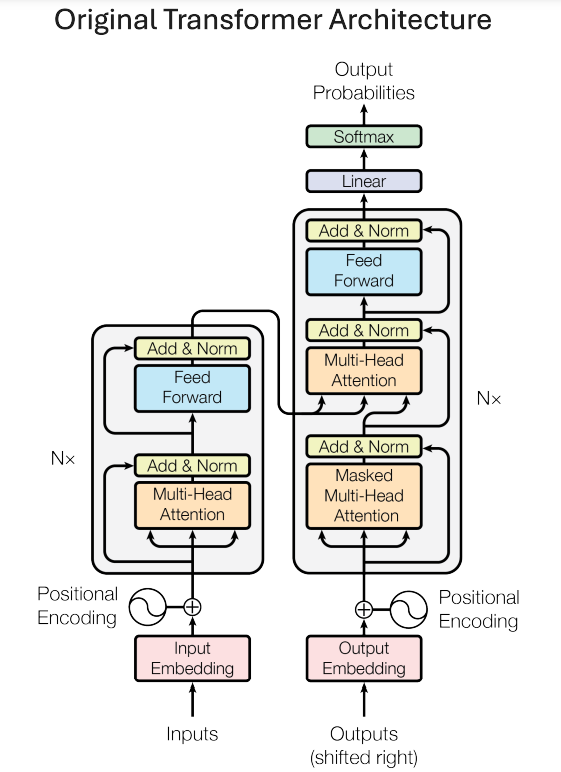

# Build a Decoder Only Transformer from scratch


In [3]:
# Import relevant libraries

! pip install -q lightning

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import lightning as L
# Ignore all warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Position encoding

In [4]:
# An illustration of position encoding
d = 5
i = 0
pos = torch.arange(0,d)
np.sin(pos/10000**(2*i/d)),np.cos(pos/10000**(2*i/d))

(tensor([ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568]),
 tensor([ 1.0000,  0.5403, -0.4161, -0.9900, -0.6536]))

In [5]:
pos_encoding = []
pos = 1
for i in range(2):
  pos_encoding.append(np.sin(pos/10000**(2*i/d)))
  pos_encoding.append(np.cos(pos/10000**(2*i/d)))
  # print(np.sin(pos/10000**(2*i/d)),np.cos(pos/10000**(2*i/d)))
pos_encoding

[0.8414709848078965,
 0.5403023058681398,
 0.025116222909773774,
 0.9996845379152098]

In [6]:
# Write a function to create a matrix that would pre-compute the position encoding for all possible steps
class PositionEncoding(nn.Module):
  def __init__ (self, d_model = 2, max_len = 6):
    super().__init__()
    pe = torch.zeros(max_len, d_model)

    # get positions of each token
    position = torch.arange(0,max_len,step = 1).float().unsqueeze(1)
    embedding_matrix = torch.arange(start = 0, end = d_model, step = 2).float()
    div_term = 1/torch.tensor(10000.0** embedding_matrix/d_model)

    pe[:, 0::2] = torch.sin(position*div_term)
    pe[:, 1::2] = torch.cos(position*div_term)
    self.register_buffer('pe', pe)

  def forward(self, word_embeddings):
    return word_embeddings + self.pe[:word_embeddings.size(0),:]

## Masked Self-attention Mechanism

In [7]:
class Attention(nn.Module):
  def __init__ (self, d_model = 2):
    super().__init__()

    self.W_q = nn.Linear(in_features = d_model, out_features = d_model, bias = False)
    self.W_k = nn.Linear(in_features = d_model, out_features = d_model, bias = False)
    self.W_v = nn.Linear(in_features = d_model, out_features = d_model, bias = False)

    # This is just to keep track of what is row and what is col
    self.row_dim = 0
    self.col_dim = 1

  # Here we give flexibility to include different sources of Q, K, V matrix
  # This allows us to convert this into Encoder-Decoder attention if we want to
  # Also passing mask variable if we want to convert to masked self attention (decoder)
  def forward(self, encodings_for_q, encodings_for_k, encodings_for_v,mask = None):

    q = self.W_q(encodings_for_q)
    k = self.W_k(encodings_for_k)
    v = self.W_v(encodings_for_v)

    # Actual attention calc
    sims = torch.matmul(q, k.transpose(dim0 = self.row_dim, dim1 = self.col_dim))

    # Scaling similar to the 2017 paper
    scaled_sims = sims/torch.tensor(k.size(self.col_dim)**0.5)


    if mask is not None:
      scaled_sims = scaled_sims.masked_fill(mask=mask, value =-1e9)

    attention_percents = F.softmax(scaled_sims, dim = self.col_dim)

    attention_scores = torch.matmul(attention_percents,v)

    return attention_scores


## Decoder only Transformer class

> The Word embeddings are initiated here randomly

> Positional encoding is added

> Masked self attention is computed

> Residula connection is added at the end


In [8]:
class DecoderOnlyTransformer(L.LightningModule):
  def __init__(self, num_tokens = 4, d_model = 2, max_len = 6):
    super().__init__()
    L.seed_everything(seed=42)

    self.we = nn.Embedding(num_embeddings=num_tokens, embedding_dim=d_model)
    self.pe = PositionEncoding(d_model= d_model, max_len = max_len)
    self.self_attention = Attention(d_model = d_model)
    self.fc_layer = nn.Linear(in_features = d_model, out_features = num_tokens)
    self.loss = nn.CrossEntropyLoss(ignore_index=-1)

  def forward(self, token_ids, attention_mask=None):
    # batch_size, seq_len = token_ids.shape
    batch_size = seq_len = token_ids.size(dim = 0)
    word_embeddings = self.we(token_ids)
    position_encoded = self.pe(word_embeddings)
    mask = torch.tril(torch.ones(token_ids.size(dim = 0), token_ids.size(dim = 0)))
    mask = mask == 0
    final_mask = mask

    self_attention_values = self.self_attention(position_encoded,position_encoded,position_encoded,mask = final_mask)

    residual_connections_values = self_attention_values + position_encoded

    fc_layer_output = self.fc_layer(residual_connections_values)

    return fc_layer_output

  def configure_optimizers(self):
    return Adam(self.parameters(), lr = 0.1)

  def training_step(self, batch, batch_idx):
    # input_tokens, labels,attention_mask = batch
    input_tokens, labels= batch
    output = self.forward(input_tokens[0])
    loss = self.loss(output, labels[0])
    return loss


## Get Training data - Simple task

**Start with a simple task to train a transformer with a small data**

In [9]:
token_to_id = {
    "how":0,
    "is":1,
    "the":2,
    "weather":3,
    "today":4,
    "pleasant":5,
    "yes":6,
    "<EOS>":7 }

id_to_token = {v: k for k,v in token_to_id.items()}
print("Token to Index dict:", token_to_id)
print("Index to Token dict:", id_to_token)

Token to Index dict: {'how': 0, 'is': 1, 'the': 2, 'weather': 3, 'today': 4, 'pleasant': 5, 'yes': 6, '<EOS>': 7}
Index to Token dict: {0: 'how', 1: 'is', 2: 'the', 3: 'weather', 4: 'today', 5: 'pleasant', 6: 'yes', 7: '<EOS>'}


In [10]:
inputs = torch.tensor([[token_to_id["how"],
                       token_to_id["is"],
                       token_to_id["the"],
                        token_to_id["weather"],
                        token_to_id["today"],
                       token_to_id["<EOS>"],
                       token_to_id["pleasant"],],

                      [token_to_id["is"],
                       token_to_id["the"],
                       token_to_id["weather"],
                       token_to_id["pleasant"],
                       token_to_id["today"],
                       token_to_id["<EOS>"],
                       token_to_id["yes"]]])

labels = torch.tensor([[token_to_id["is"],
                        token_to_id["the"],
                        token_to_id["weather"],
                        token_to_id["today"],
                        token_to_id["<EOS>"],
                        token_to_id["pleasant"],
                        token_to_id["<EOS>"]],
                      [token_to_id["the"],
                       token_to_id["weather"],
                       token_to_id["pleasant"],
                       token_to_id["today"],
                       token_to_id["<EOS>"],
                       token_to_id["yes"],
                       token_to_id["<EOS>"]]])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

## Model Initialization

In [11]:
"""
num_tokens --> vocabulary
d_model    --> Dimension of the embedding vector
max_len    --> Context Length of inputs
"""

model = DecoderOnlyTransformer( num_tokens= len(token_to_id), d_model = 2, max_len = 8)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


## Train the model

In [12]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model, train_dataloaders=dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | we             | Embedding        | 16     | train
1 | pe             | PositionEncoding | 0      | train
2 | self_attention | Attention        | 12     | train
3 | fc_layer       | Linear           | 24     | train
4 | loss           | CrossEntropyLoss | 0      | train
------------------------------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0         

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Model inference

In [13]:
# Prompt 1
prompt = "how is the weather today"
prompt_index = [token_to_id[each] for each in prompt.split()] + [token_to_id["<EOS>"]] # Adding EOS token at the end as a default
print(prompt_index)

[0, 1, 2, 3, 4, 7]


In [14]:
# model = DecoderOnlyTransformer( num_tokens= len(token_to_id), d_model = 2, max_len = 6)

model_input = torch.tensor(prompt_index)

input_length = model_input.size(dim=0)
predictions = model(model_input)
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

max_length = 6

for i in range(input_length, max_length):
  if predicted_id == token_to_id["<EOS>"]:
    break

  model_input = torch.cat((model_input, predicted_id))
  predictions = model(model_input)
  predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
  predicted_ids = torch.cat((predicted_ids, predicted_id))

In [15]:
print("Prompt:", prompt)
print("Model Response:", ''.join([id_to_token[each.item()] for each in predicted_ids]))

Prompt: how is the weather today
Model Response: pleasant


In [16]:
# Prompt 2
prompt = "is the weather pleasant today"
prompt_index = [token_to_id[each] for each in prompt.split()] + [token_to_id["<EOS>"]] # Adding EOS token at the end as a default
print(prompt_index)

[1, 2, 3, 5, 4, 7]


In [17]:
model_input = torch.tensor(prompt_index)

input_length = model_input.size(dim=0)
predictions = model(model_input)
# print(predictions, predictions.size())
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

max_length = 6

for i in range(input_length, max_length):
  if predicted_id == token_to_id["<EOS>"]:
    break

  model_input = torch.cat((model_input, predicted_id))
  predictions = model(model_input)
  predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
  predicted_ids = torch.cat((predicted_ids, predicted_id))

In [18]:
print("Prompt:", prompt)
print("Model Response:", ''.join([id_to_token[each.item()] for each in predicted_ids]))

Prompt: is the weather pleasant today
Model Response: yes


# Decoder Only Transformer for sentence completion task

**CNN dataset is used to train the model**

In [19]:
!pip install -q datasets
!pip install -q contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.9 MB/s eta 0:00:00


In [20]:
from datasets import load_dataset
import nltk
import regex as re
from contractions import contractions_dict
import torch
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


# dataset = load_dataset("ccdv/cnn_dailymail", '3.0.0', trust_remote_code=True)
dataset = load_dataset("cnn_dailymail", "3.0.0")

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [21]:
# Helper functions to prepare data
def get_data_corpus(data, n):
  """Gets the entire data into one big string"""
  corp = ''
  for i in range(n):
    corp = corp + ' '+ data['train'][i]['article']
  return corp

def expand_contractions(text, contraction_map=contractions_dict):
  """Get expanded contractions"""
  con_key = '|'.join(contraction_map.keys())
  cppp = re.compile(f'({con_key})', flags=re.DOTALL)

  def e_m(contraction):
      match = contraction.group(0)
      exp_c = contraction_map.get(match)
      if not expand_contractions:
          print(match)
          return match
      return exp_c

  text_e = cppp.sub(e_m, text)
  text_e = re.sub("'", "", text_e)
  return text_e

def get_clean_data(input_text):
  """Removes punctuations and cleans data"""

  column_string = input_text #' '.join(dd['article'][0:250].tolist()) # Get rows to one big string

  column_string = expand_contractions(column_string)  # Expand contractions
  column_string = re.sub(r'-', ' ', column_string) # Replace hyphens with space

  column_string = re.sub("[^A-Za-z .]", "" , column_string) # Remove punctuations - in case we need to include more punctuations -> re.sub("[^a-zA-Z :\.]", "", line)
  column_string = column_string.lower() # Convert to lowercase
  column_string = re.sub(r'\.', " . ", column_string) # Replace dot with space and dot
  column_string = re.sub(r'\.', "<EOS>", column_string) # Replace dot with <EOS> token
  column_string = re.sub("\s+"," ",column_string) # Remove extra spaces
  return column_string

def tokenize_text(text):
  """Tokenization function (splitting by words and replacing "'" with <EOS>)"""
  tokens = text.replace(".", " <EOS> ").split()  # Replace apostrophe and split
  unique_tokens = sorted(set(tokens))  # Get unique tokens sorted
  token_dict = {token: idx for idx, token in enumerate(unique_tokens)}  # Assign token IDs
  return tokens, token_dict

def get_dicts(column_string):
  """Apply tokenization and get dicts = token_to_id and id_to_token"""
  tokens, t_to_i = tokenize_text(column_string)
  i_to_t = {v:k for k,v in t_to_i.items()}
  return t_to_i, i_to_t


In [22]:
# Prepare inputs and labels
def prepare_inputs_labels(sentence_list, t_to_i):
  inputs_tensor = []
  labels_tensor = []
  for each_sent in sentence_list:
    current_inputs_list = [t_to_i[each_token] for each_token in each_sent]
    current_inputs_tensor = torch.tensor(current_inputs_list)
    current_labels_tensor = torch.cat((current_inputs_tensor[1:], torch.tensor([t_to_i['<EOS>']])))

    inputs_tensor.append(current_inputs_tensor)
    labels_tensor.append(current_labels_tensor)
  return inputs_tensor, labels_tensor

## Get the training data

In [23]:
# Get all data from first n articles and clean them up
n = 100
corpus = get_data_corpus(dataset, n)
cleaned_corpus = get_clean_data(corpus)

# Consider the sentences which are of length 6 -- this is a simplified strategy to build a simple model
sentences = cleaned_corpus.split('<EOS>')
words_in_sent = [each_sen.split() for each_sen in sentences]
sent_keep = ''
sent_list = []
for each in words_in_sent:
  if len(each) == 6:
    sent_keep = sent_keep + ' '.join(each) + ' <EOS> '
    sent_list.append(each)

# Get the vocabulary i.e - token to index and index to tokens
token_to_id, id_to_token = get_dicts(sent_keep)

In [24]:
# Prepare input and output just how we did before
a,b = prepare_inputs_labels(sent_list, token_to_id)
dataset_new = TensorDataset(torch.stack(a),torch.stack(b))
dataloader = DataLoader(dataset_new) #dataloader for training on lightning

## Define the Transformer model - based on CNN data

In [25]:
# model based on CNN data input and labels
model = DecoderOnlyTransformer( num_tokens= len(token_to_id), d_model = 8, max_len = 10)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


## Train the model

In [26]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model, train_dataloaders=dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | we             | Embedding        | 2.9 K  | train
1 | pe             | PositionEncoding | 0      | train
2 | self_attention | Attention        | 192    | train
3 | fc_layer       | Linear           | 3.2 K  | train
4 | loss           | CrossEntropyLoss | 0      | train
------------------------------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)
8         Modules in train mode
0         

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Model inference

In [27]:
prompt = "i like"

prompt_index = [token_to_id[each] for each in prompt.split()] + [token_to_id["<EOS>"]] # Adding EOS token at the end as a default
print(prompt_index)

[141, 169, 0]


In [30]:
model_input = torch.tensor(prompt_index)

input_length = model_input.size(dim=0)
predictions = model(model_input)
# print(predictions, predictions.size())
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

max_length = 6

for i in range(input_length, max_length):
  if predicted_id == token_to_id["<EOS>"]:
    break

  model_input = torch.cat((model_input, predicted_id))
  predictions = model(model_input)
  predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
  predicted_ids = torch.cat((predicted_ids, predicted_id))

In [31]:
print("Prompt:", prompt)
print("Model Response:", ''.join([id_to_token[each.item()] for each in predicted_ids]))

Prompt: i like
Model Response: u<EOS>
